In [1]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

^C
ERROR: Operation cancelled by user


In [14]:
import numpy as np 

class ExperienceReplayBuffer: 
    def __init__(self, max_memory, input_shape, n_actions): 
        self.mem_size = max_memory
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_experience(self, state, action, reward, next_state, done): 
        index = self.mem_counter % self.mem_size 

        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1
        

    def sample_experience(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch_index = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch_index]
        next_states = self.new_state_memory[batch_index]
        rewards = self.reward_memory[batch_index]
        actions = self.action_memory[batch_index]
        terminal = self.terminal_memory[batch_index]

        return states, actions, rewards, next_states, terminal


In [26]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, Input


class DeepQNetwork2D(keras.Model):
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork2D, self).__init__()
     #   self.fc1 = Dense(64, activation='relu')
        self.fc1 = Dense(64, activation='relu', , input_shape=input_dims)
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(n_actions, activation=None)

    def call(self, state):

        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class DeepQNetwork3D(keras.Model): 
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork3D, self).__init__()

        self.conv1 = Conv2D(32, 8, strides=(4, 4), activation='relu', data_format="channels_first", input_shape=input_dims)
        self.conv2 = Conv2D(32, 4, strides=(2, 2), activation='relu', data_format="channels_first")
        self.conv3 = Conv2D(64, 3, strides=(1, 1), activation='relu', data_format="channels_first")
        self.flatten = Flatten()

        self.fc2 = Dense(128, activation='relu')
        self.fc3 = Dense(n_actions, activation=None)

    def call(self, state):

        x = self.conv1(state)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [16]:
import numpy as np

def epsilon_greedy_policy(q_val_network, observation, action_space, epsilon):
        if np.random.random() > epsilon:
            state = tf.convert_to_tensor([observation])
            actions = q_val_network(state, verbose=0)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(action_space)
        return action


def greedy_policy(observation, q_val_network, action_space): 
    state = tf.convert_to_tensor([observation])
    actions = q_val_network(state)
    action = tf.math.argmax(actions, axis=1).numpy()[0]
    return action


In [17]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam, RMSprop

#https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/tf2/agent.py
class Agent: 
    def __init__(self, agent_params):
        # Parameters
        self.gamma = agent_params.get("gamma")
        self.lr = agent_params.get("lr")
        self.input_dims = agent_params.get("input_dims")
        self.batch_size = agent_params.get("batch_size")
        self.replace_target_weight_counter = agent_params.get("replace")
        self.algo = agent_params.get("algo")
        self.env_name = agent_params.get("env_name")
        self.chkpt_dir = agent_params.get("chkpt_dir")
        self.n_actions = agent_params.get("n_actions")
        self.action_space = agent_params.get('actions')
        
        self.eps = agent_params.get("eps")
        self.min_eps = agent_params.get("min_eps")
        self.eps_decay_rate = agent_params.get("eps_decay_rate")
        
        self.learn_step_counter = 0
        self.fname = self.chkpt_dir + self.env_name + '_' + self.algo + '_'
        self.mem_size = agent_params.get("mem_size")
        
        self.TAU = agent_params.get("tau")
        self.soft_update = agent_params.get("soft_update")

        # networks and replaybuffer
        self.memory = ExperienceReplayBuffer(self.mem_size, self.input_dims, self.n_actions)
        self.q_value_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.q_value_network.compile(optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01))
        self.target_q_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.target_q_network.compile(optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01))

    def save_models(self):
        self.q_value_network.save(self.fname+'q_value')
        self.target_q_network.save(self.fname+'target_q')
        print('... models saved successfully ...')

    def load_models(self):
        self.q_value_network = keras.models.load_model(self.fname+'q_value')
        self.target_q_network = keras.models.load_model(self.fname+'target_q')
        print('... models loaded successfully ...')

    def store_experience(self, state, action, reward, state_, done):
        self.memory.store_experience(state, action, reward, state_, done)

    def sample_experience(self):
        state, action, reward, new_state, done = \
                                  self.memory.sample_experience(self.batch_size)
        states = tf.convert_to_tensor(state)
        rewards = tf.convert_to_tensor(reward)
        dones = tf.convert_to_tensor(done)
        actions = tf.convert_to_tensor(action, dtype=tf.int32)
        states_ = tf.convert_to_tensor(new_state)
        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.eps:
            state = tf.convert_to_tensor([observation])
            actions = self.q_value_network(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(self.action_space)
        return action

    def replace_target_network(self):
        if not self.soft_update:
            self.target_q_network.set_weights(self.q_value_network.get_weights())
            return
        else: 
            q_model_theta = self.q_value_network.get_weights()
            target_model_theta = self.target_q_network.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_q_network.set_weights(target_model_theta)
    
    def decrement_epsilon(self): 
        self.eps -= self.eps_decay_rate
        self.eps = max(self.eps, self.min_eps)

    def learn(self):

        if self.memory.mem_counter < self.batch_size:
            return

        self.replace_target_network()
        
        states, actions, rewards, states_, dones = self.sample_experience()

        with tf.GradientTape() as tape:
        
            q_pred = self.q_value_network(states, verbose=False)
            q_next_val = self.q_value_network(states_, verbose=False)
            
            q_pred, q_next_val = q_pred.numpy(), q_next_val.numpy()
            
            q_target = q_pred.copy()

            q_eval = self.target_q_network(states_, verbose=False)
            max_action_ids = np.argmax(q_next_val, axis=1)

            q_target[[np.arange(self.batch_size)], max_action_ids] = rewards[np.arange(self.batch_size)] + self.gamma * q_eval[[np.arange(self.batch_size)], max_action_ids]  * (1 - dones[np.arange(self.batch_size)])
            
            loss = keras.losses.MSE(tf.to_tensor(q_pred), tf.to_tensor(q_target))
        
        params = self.q_value_network.trainable_variables
        grads = tape.gradient(loss, params)
        self.q_value_network.optimizer.apply_gradients(zip(grads, params))
        
        self.learn_step_counter += 1
        self.decrement_epsilon()       

In [18]:
    """
    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_experience()

        indices = tf.range(self.batch_size, dtype=tf.int32)
        action_indices = tf.stack([indices, actions], axis=1)

        with tf.GradientTape() as tape:
            q_pred = tf.gather_nd(self.q_value_network(states), indices=action_indices)
            q_next = self.target_q_network(states_)
            q_eval = self.q_value_network(states_)

            max_actions = tf.math.argmax(q_eval, axis=1, output_type=tf.int32)
            max_action_idx = tf.stack([indices, max_actions], axis=1)

            q_target = rewards + \
                self.gamma*tf.gather_nd(q_next, indices=max_action_idx) *\
                (1 - dones.numpy())

            loss = keras.losses.MSE(q_pred, q_target)

        params = self.q_value_network.trainable_variables
        grads = tape.gradient(loss, params)

        self.q_value_network.optimizer.apply_gradients(zip(grads, params))

        self.learn_step_counter += 1

        self.decrement_epsilon()
        return self.eps
    """

'\ndef learn(self):\n    if self.memory.mem_counter < self.batch_size:\n        return\n\n    self.replace_target_network()\n\n    states, actions, rewards, states_, dones = self.sample_experience()\n\n    indices = tf.range(self.batch_size, dtype=tf.int32)\n  \n    action_indices = tf.stack([indices, actions], axis=1)\n\n    \n    q_target = self.q_value_network.predict(states, verbose=False)\n    q_next_val = self.q_value_network.predict(states_, verbose=False)\n        \n    q_eval = self.target_q_network.predict(states_, verbose=False)\n    max_action_ids = np.argmax(q_next_val, axis=1)\n        \n    q_target[[np.arange(self.batch_size)], max_action_ids] = rewards[i] + self.gamma * q_eval[[np.arange(self.batch_size)], max_action_ids]  * (1 - dones[i].numpy())\n\n    self.learn_step_counter += 1\n    self.decrement_epsilon()\n    \n    self.q_value_network.fit(states, q_target, batch_size=self.batch_size, epochs=1, verbose=False)\n    \n\n'

In [19]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        print("yes")
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [20]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [21]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)


In [22]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [23]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, trainer_params): 
       
        self.env = env 
        self.noe = trainer_params.get("noe")
        self.max_steps = trainer_params.get("max_steps")
       
        self.eps_decay_rate = trainer_params.get("eps_decay_rate")
        self.action_space = trainer_params.get("action_space")
        self.is_tg = trainer_params.get("is_tg")
        self.tg_bot_freq_epi = trainer_params.get("tg_bot_freq_epi")
        self.record = trainer_params.get("record")
        self.agent_params = {
                        "gamma":  trainer_params.get("gamma"), 
                        "lr":  trainer_params.get("lr"), 
                        "input_dims":  trainer_params.get("input_dims"),
                        "mem_size" :  trainer_params.get("mem_size"),
                        "batch_size" :  trainer_params.get("batch_size"),
                        "replace" :  trainer_params.get("replace"),
                        "algo" :  trainer_params.get("algo"),
                        "env_name" :  trainer_params.get("env_name"),
                        "n_actions" :  trainer_params.get("n_actions"),
                        "chkpt_dir":  trainer_params.get("chkpt_dir"),
                        "actions":  trainer_params.get("actions"),
                        "eps": trainer_params.get("eps"),
                        "min_eps": trainer_params.get("min_eps"),
                        "eps_decay_rate": trainer_params.get("eps_decay_rate"),
                        "tau": trainer_params.get("tau"), 
                        "soft_update": trainer_params.get("soft_update")
                    }
        
        self.agent = Agent(self.agent_params)
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo(trainer_params.get("video_prefix"), "videos/", 20)
        
        self.target_score = trainer_params.get("target_score")
        self.checkpoint = trainer_params.get("checkpoint")
            
    def train_rl_model(self): 
        episode_rewards = []
        epsilon_history = []
        avg_rewards = []
        best_reward = float("-inf")
        
        if self.checkpoint:
            self.agent.load_models()

        for episode in range(self.noe): 
            n_steps = 0 
            episodic_loss = 0
            state = self.env.reset()
            reward = 0 
            
            if self.record and episode%100==0: 
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 
                
                if self.record and episode%100==0: 
                    img = self.env.render()
                    self.recorder.add_image(img)

                if type(state) == tuple: 
                    state = state[0]
                state = state

                action = self.agent.choose_action(state)

                next_info = self.env.step(action)
                next_state, reward_prob, terminated, truncated, _ = next_info
                done = truncated or terminated
                reward += reward_prob

                self.agent.store_experience(state, action, reward_prob, next_state, done)
                eps = self.agent.learn()

                state = next_state
                n_steps += 1 
               
                
                if done: 
                    break

            epsilon_history.append(eps)
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

            result = f"Episode: {episode}, Epsilon: {eps}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            print(result)
            
            # Saving Best Model
            if reward > best_reward: 
                best_reward = reward
                self.agent.save_models()
            
            # video Recorder
            if episode % 100 ==0:
                self.recorder.save(episode)
                
          # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
         # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-100:]) >= self.target_score: 
                break
                
                
        return episode_rewards, epsilon_history, avg_rewards, best_reward

In [ ]:
import gymnasium as gym
import time

env = make_env("ALE/Pong-v5", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]

episodic_rewards_filename = 'array_files/episodic_reward.npy'
epsilon_history_filename = 'array_files/epsilon_history.npy'
cum_avg_reward_filename = 'array_files/cum_avg_rewards.npy'
losses_filename = 'array_files/losses.npy'

trainer_params = {
    "noe": 1000, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-4,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.95, 
    "lr": 0.0005, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 100000,
    "batch_size" : 32,
    "replace" : 150,
    "algo" : "DDQN",
    "env_name" : "lunarlander",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/ddqn/",
    "actions": action_space,
    "target_score": 100,
    "tau": 0.1,
    "soft_update": True,
    "video_prefix": "ddqn"
}


if __name__ == "__main__": 
    try: 
        manage_memory()
        
        trainer = Trainer(env, trainer_params)

        episode_rewards, avg_rewards, best_reward = trainer.train_rl_model()
    #    plot_learning_curve(episode_rewards, "plot_file")

       # eval_model(env, "keras model", "videos/", fps=10)
    
    except Exception as error:
        raise error


Episode: 0, Epsilon: 0.9963000000000004, Steps: 68, Reward: -115.96582095859624, Best reward: -inf, Avg reward: -115.96582095859624
... models saved successfully ...


[swscaler @ 0x603e200] Warning: data is not aligned! This can lead to a speed loss


Episode: 1, Epsilon: 0.9873000000000014, Steps: 90, Reward: -288.68509102899606, Best reward: -115.96582095859624, Avg reward: -202.32545599379614
Episode: 2, Epsilon: 0.9764000000000026, Steps: 109, Reward: -221.91340194686484, Best reward: -115.96582095859624, Avg reward: -208.8547713114857
Episode: 3, Epsilon: 0.9648000000000039, Steps: 116, Reward: -93.53937740866279, Best reward: -115.96582095859624, Avg reward: -180.02592283577997
... models saved successfully ...
Episode: 4, Epsilon: 0.9556000000000049, Steps: 92, Reward: -13.561490912417185, Best reward: -93.53937740866279, Avg reward: -146.7330364511074
... models saved successfully ...
Episode: 5, Epsilon: 0.9488000000000056, Steps: 68, Reward: -186.24348612461364, Best reward: -13.561490912417185, Avg reward: -153.31811139669176
Episode: 6, Epsilon: 0.9412000000000065, Steps: 76, Reward: -42.043738311828875, Best reward: -13.561490912417185, Avg reward: -137.4217723845685
Episode: 7, Epsilon: 0.9330000000000074, Steps: 82, R

[swscaler @ 0x5c49200] Warning: data is not aligned! This can lead to a speed loss


Episode: 101, Epsilon: 0.1, Steps: 1000, Reward: -35.186329387894666, Best reward: 34.432722540912366, Avg reward: -88.11767062909327
Episode: 102, Epsilon: 0.1, Steps: 1000, Reward: 19.833398177340346, Best reward: 34.432722540912366, Avg reward: -85.70020262785121
Episode: 103, Epsilon: 0.1, Steps: 1000, Reward: 10.539933449523419, Best reward: 34.432722540912366, Avg reward: -84.65940951926932
Episode: 104, Epsilon: 0.1, Steps: 1000, Reward: -21.133037373910714, Best reward: 34.432722540912366, Avg reward: -84.73512498388428
Episode: 105, Epsilon: 0.1, Steps: 1000, Reward: -0.6266529140022583, Best reward: 34.432722540912366, Avg reward: -82.87895665177817
Episode: 106, Epsilon: 0.1, Steps: 1000, Reward: -39.94103178487826, Best reward: 34.432722540912366, Avg reward: -82.85792958650867
Episode: 107, Epsilon: 0.1, Steps: 1000, Reward: 1.2400602640503067, Best reward: 34.432722540912366, Avg reward: -81.90803005447147
Episode: 108, Epsilon: 0.1, Steps: 1000, Reward: -4.59739397292351

[swscaler @ 0x5db7200] Warning: data is not aligned! This can lead to a speed loss


Episode: 201, Epsilon: 0.1, Steps: 686, Reward: 288.91548924070435, Best reward: 281.18477364750095, Avg reward: 75.17631972722201
... models saved successfully ...
Episode: 202, Epsilon: 0.1, Steps: 668, Reward: 302.6718960480857, Best reward: 288.91548924070435, Avg reward: 78.00470470592947
... models saved successfully ...
Episode: 203, Epsilon: 0.1, Steps: 392, Reward: 260.0111463995806, Best reward: 302.6718960480857, Avg reward: 80.49941683543004
Episode: 204, Epsilon: 0.1, Steps: 231, Reward: -78.84006190533422, Best reward: 302.6718960480857, Avg reward: 79.92234659011581
Episode: 205, Epsilon: 0.1, Steps: 162, Reward: -1.219035936657903, Best reward: 302.6718960480857, Avg reward: 79.91642275988924
Episode: 206, Epsilon: 0.1, Steps: 302, Reward: 257.8751666156711, Best reward: 302.6718960480857, Avg reward: 82.89458474389474
Episode: 207, Epsilon: 0.1, Steps: 486, Reward: -25.46990587962597, Best reward: 302.6718960480857, Avg reward: 82.62748508245797
Episode: 208, Epsilon: 

[swscaler @ 0x6dbc200] Warning: data is not aligned! This can lead to a speed loss


Episode: 301, Epsilon: 0.1, Steps: 126, Reward: -8.835234163861642, Best reward: 304.45689066641376, Avg reward: 149.02736802173698
Episode: 302, Epsilon: 0.1, Steps: 239, Reward: 239.6086051647276, Best reward: 304.45689066641376, Avg reward: 148.3967351129034
Episode: 303, Epsilon: 0.1, Steps: 373, Reward: 237.16852153335967, Best reward: 304.45689066641376, Avg reward: 148.1683088642412
Episode: 304, Epsilon: 0.1, Steps: 565, Reward: 210.85252795950504, Best reward: 304.45689066641376, Avg reward: 151.06523476288956
Episode: 305, Epsilon: 0.1, Steps: 102, Reward: -70.77224684952206, Best reward: 304.45689066641376, Avg reward: 150.36970265376092
Episode: 306, Epsilon: 0.1, Steps: 414, Reward: 227.3124605147689, Best reward: 304.45689066641376, Avg reward: 150.06407559275192
Episode: 307, Epsilon: 0.1, Steps: 464, Reward: 241.80388212750483, Best reward: 304.45689066641376, Avg reward: 152.7368134728232
Episode: 308, Epsilon: 0.1, Steps: 211, Reward: 320.3928236417836, Best reward: 3

[swscaler @ 0x749e200] Warning: data is not aligned! This can lead to a speed loss


Episode: 501, Epsilon: 0.1, Steps: 513, Reward: 224.3989907508593, Best reward: 320.3928236417836, Avg reward: 191.53060662420182
Episode: 502, Epsilon: 0.1, Steps: 174, Reward: 47.383241374978894, Best reward: 320.3928236417836, Avg reward: 194.78587724718855
Episode: 503, Epsilon: 0.1, Steps: 926, Reward: 212.4936645193525, Best reward: 320.3928236417836, Avg reward: 193.79085809366944
Episode: 504, Epsilon: 0.1, Steps: 204, Reward: -5.048939709834983, Best reward: 320.3928236417836, Avg reward: 193.76289259314242
Episode: 505, Epsilon: 0.1, Steps: 346, Reward: 222.60060850353062, Best reward: 320.3928236417836, Avg reward: 193.41677118087443
Episode: 506, Epsilon: 0.1, Steps: 146, Reward: 68.45783366376472, Best reward: 320.3928236417836, Avg reward: 194.75123812990645
Episode: 507, Epsilon: 0.1, Steps: 365, Reward: 245.64136071641124, Best reward: 320.3928236417836, Avg reward: 195.54153600761612
Episode: 508, Epsilon: 0.1, Steps: 324, Reward: 233.27528061177372, Best reward: 320.3

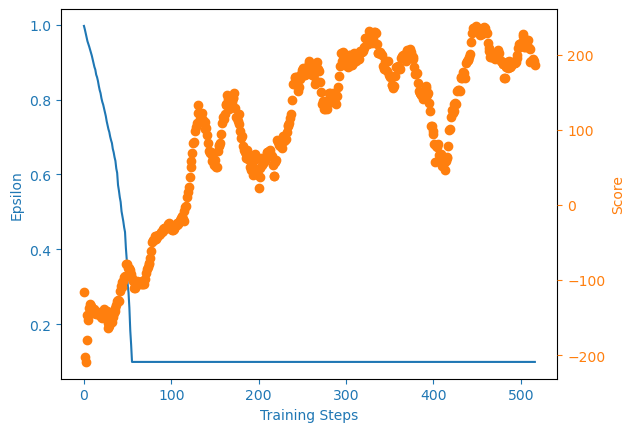

In [28]:
import gymnasium as gym
import time
import signal
import time
import sys
import pickle

env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
record = True


trainer_params = {
    "noe": 650, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-4,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.99, 
    "lr": 0.0001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 100000,
    "batch_size" : 32,
    "replace" : 150,
    "algo" : "DDQN",
    "env_name" : "lunarlander",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/ddqn/",
    "actions": action_space,
    "target_score": 200,
    "tau": 0.1,
    "soft_update": True,
    "video_prefix": "ddqn",
    "checkpoint": False
}

    
if __name__ == "__main__": 
    
    try: 
        manage_memory()
       
        trainer = Trainer(env, trainer_params)
        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("ddqn_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("ddqn_epsilon_history.obj", "wb") as f: 
            pickle.dump(epsilon_history, f)
        
        with open("ddqn_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        plot_learning_curve(episode_rewards, epsilon_history, "vanilla_ddqn")
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)


In [29]:
import random 
import imageio
import tensorflow as tf   
    
    
          

class Eval: 

    def __init__(self, env, model_path, action_space, number_of_episode=50, test_video_path="test_videos/"):
        self.env = env 
        self.model = tf.keras.models.load_model(model_path)
        self.recorder = RecordVideo('dqn_lunarlander_test', test_video_path, 15)
        self.number_of_episode = number_of_episode
        self.action_space = action_space
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state = env.reset(seed=random.randint(0,500))
            if episode % 5 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:
                if type(state) == tuple: 
                    state = state[0]
                    
                action =  greedy_policy(state, self.model, self.action_space)
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 10 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
            self.recorder.save(1) if episode % 5 == 0 else None
        
        return rewards, steps                                                                                                                                                        


In [35]:
env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
model_path = "/kaggle/working/tmp/ddqn/lunarlander_DDQN_q_value/"

eval = Eval(env, model_path, action_space, 1)

In [38]:
test_rewards, steps = eval.test()

[swscaler @ 0x73e4200] Warning: data is not aligned! This can lead to a speed loss


In [39]:
test_rewards

[253.02580494015186]